In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
from joblib import Parallel, delayed

In [2]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq
output_dir = project_dir + '/Output'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16

In [3]:
cryptic_input_path = "D:/Project_Data/CRYPTIC_DATA/"
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"

In [4]:
lineage_info_df = pd.read_csv(cryptic_input_path + 'MYKROBE_LINEAGE.csv')
lineage_info_dict = {}
for i, r in lineage_info_df.iterrows():
    lineage_info_dict[r['UNIQUEID']] = r['MYKROBE_LINEAGE_NAME_2']

In [ ]:
if 1==1:
    num_rows = 0
    num_exceptions = 0
    variant_count_dict = {}
    chunksize = 0.5 * (10 ** 7) 
    chunknum = 1
    with pd.read_csv(cryptic_input_path + "VARIANTS.csv", chunksize=chunksize) as reader:
        for chunk in reader:
            print("Chunk " + str(chunknum)) 
            chunknum += 1
            for i, r in chunk.iterrows():
                num_rows += 1
                if r['UNIQUEID'] in lineage_info_dict:
                    lineage = lineage_info_dict[r['UNIQUEID']]
                    if (lineage,r['GENOME_INDEX'], r['MUTATION_TYPE'], r['ALT']) in variant_count_dict:
                        variant_count_dict[(lineage, r['GENOME_INDEX'], r['MUTATION_TYPE'], r['ALT'])] = variant_count_dict[(lineage, r['GENOME_INDEX'], r['MUTATION_TYPE'], r['ALT'])] + 1
                    else:
                        variant_count_dict[(lineage, r['GENOME_INDEX'], r['MUTATION_TYPE'],r['ALT'])] = 1
                else:
                    num_exceptions +=1
            print(num_exceptions, num_rows)
    with open(cryptic_output_path + '/' + 'variant_count_by_lineage_dictionary.pkl', 'wb') as f:
        pickle.dump(variant_count_dict, f)

In [7]:
nick = pd.read_csv(cryptic_input_path + 'MYKROBE_LINEAGE.csv')

In [15]:
temp1 = pd.read_csv(cryptic_input_path + 'MYKROBE_LINEAGE.csv')
temp2 = list(temp['MYKROBE_LINEAGE_NAME_2'].unique())
[x for x in temp2 if not('/' in x) and not (x=='Unknown') and not('clade' in x) and not('Bovis' in x) and not('Caprae' in x)]

['lineage2.2',
 'lineage2.2.2',
 'lineage4.10',
 'lineage4.5',
 'lineage2.2.3',
 'lineage2.2.6',
 'lineage1.2.1',
 'lineage4.3.3',
 'lineage3',
 'lineage4.2.2',
 'lineage2.2.7',
 'lineage2.2.5',
 'lineage4.4.2',
 'lineage4.3.4.1',
 'lineage2.2.4',
 'lineage1.2.2',
 'lineage4.2.1',
 'lineage2.1',
 'lineage4',
 'lineage2.2.1',
 'lineage2.2.8',
 'lineage4.1.2.1',
 'lineage1.1.1.1',
 'lineage4.3.4.2',
 'lineage2.2.10',
 'lineage4.1.3',
 'lineage2.2.9',
 'lineage1.1.1',
 'lineage4.1.2',
 'lineage4.6.2.2',
 'lineage3.1.2.2',
 'lineage4.1.1.1',
 'lineage3.1.1',
 'lineage4.1.1.3',
 'lineage1.1.2',
 'lineage4.3.4.2.1',
 'lineage4.4.1.1',
 'lineage4.6.2.1',
 'lineage1.1.3',
 'lineage3.1.2.1',
 'lineage4.3.1',
 'lineage4.4.1.2',
 'lineage3.1.2',
 'lineage5',
 'lineage4.1.1',
 'lineage7',
 'lineage6',
 'lineage4.2.2.1',
 'lineage4.3.2',
 'lineage4.6',
 'lineage4.6.1.2',
 'lineage4.6.1',
 'lineage4.1',
 'lineage4.3.4',
 'lineage4.6.2',
 'lineage4.3.2.1',
 'lineage4.6.1.1',
 'lineage4.4',
 'lineage4

<AxesSubplot:xlabel='MYKROBE_LINEAGE_NAME_2', ylabel='Count'>

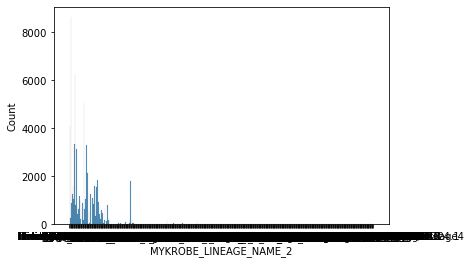

In [9]:
sns.histplot(nick['MYKROBE_LINEAGE_NAME_2'])